#Bundesliga Passing Accuracy Analysis Report Python Notebook

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

In [2]:
#loading the dataset to dataframe
match_data=pd.read_csv('passes.csv',delimiter=';')

In [3]:
#Checking number of rows and columns
match_data.shape

(306, 3)

In [4]:
#print the first 5 rows for preview of data
match_data.head()

,game_id,passing_quote,winner
0,11,72.0,No
1,11,91.0,Yes
2,12,82.0,Yes
3,12,86.0,No
4,13,82.0,Yes


In [5]:
#Checking if any null or missing value
match_data.isnull().sum()

game_id          0
passing_quote    2
winner           2
dtype: int64

In [6]:
#Checking records with Null values for passing quote and winner
print(match_data[match_data['passing_quote'].isnull()])
print(match_data[match_data['winner'].isnull()])

     game_id  passing_quote winner
232      139            NaN    NaN
233      139            NaN    NaN
     game_id  passing_quote winner
232      139            NaN    NaN
233      139            NaN    NaN


In [7]:
#Dropping the missing value records
match_data.dropna(subset=['passing_quote', 'winner'],inplace=True)
match_data.isnull().sum()

game_id          0
passing_quote    0
winner           0
dtype: int64

In [8]:
#Statistical measures of the passing acuuracy data
match_data['passing_quote'].describe()

count    304.000000
mean      79.680921
std        6.960058
min       53.000000
25%       75.000000
50%       80.000000
75%       85.000000
max       92.000000
Name: passing_quote, dtype: float64

In [9]:
# Split the data into two separate DF based on the first or second occurrence of each game_id
team1_data = match_data.groupby('game_id').nth(0).rename(columns={'passing_quote': 'team1_passing_quote', 'winner': 'team1_winner'})
team2_data = match_data.groupby('game_id').nth(1).rename(columns={'passing_quote': 'team2_passing_quote', 'winner': 'team2_winner'})

# Merging the two datasets based on game_id
match_data = pd.merge(team1_data, team2_data, on='game_id', how='inner')

# Adding columns to identify if there was outcome of the match or a draw and the difference in passing rates
match_data['game_draw'] = (match_data['team1_winner'] == 'No') & (match_data['team2_winner'] == 'No')


match_data['passing_rate_diff'] = match_data[match_data["game_draw"] == False].apply(
    lambda row: row['team1_passing_quote'] - row['team2_passing_quote'] if row['team1_winner'] == 'Yes'
    else row['team2_passing_quote'] - row['team1_passing_quote'], axis=1
)

#Abs_passing_rate_diff calculation for 2nd Research question purpose
match_data['abs_passing_rate_diff'] = abs(match_data['team1_passing_quote'] - match_data['team2_passing_quote'])

# Preview the transformed data
match_data.head()

,game_id,team1_passing_quote,team1_winner,team2_passing_quote,team2_winner,game_draw,passing_rate_diff,abs_passing_rate_diff
0,11,72.0,No,91.0,Yes,False,19.0,19.0
1,12,82.0,Yes,86.0,No,False,-4.0,4.0
2,13,82.0,Yes,79.0,No,False,3.0,3.0
3,14,79.0,No,77.0,Yes,False,-2.0,2.0
4,15,85.0,No,77.0,No,True,NaN,8.0


In [10]:
#Joined data at match ID level has 152 records
match_data.shape

(152, 8)

In [11]:
# 38 drawn games and 114 non-draw games
match_data.groupby(['game_draw']).size()

game_draw
False    114
True      38
dtype: int64

In [12]:
# Check for missing values
#(we are not calculating passing_rate_diff as we are doing for only non-draw games as per 1st research question)
match_data.isnull().sum()


game_id                   0
team1_passing_quote       0
team1_winner              0
team2_passing_quote       0
team2_winner              0
game_draw                 0
passing_rate_diff        38
abs_passing_rate_diff     0
dtype: int64

#Question
#Does the winner of a match have a statistically higher passing rate than the loser?

In [13]:
# FIltering out drawn matches for 1st Research question
non_drawn_match=match_data[match_data["game_draw"] == False]

In [14]:
#Statistical Measure for passing rate difference for non-draw games
non_drawn_match['passing_rate_diff'].describe()

count    114.000000
mean       1.815789
std        9.888373
min      -29.000000
25%       -5.000000
50%        3.000000
75%        8.000000
max       25.000000
Name: passing_rate_diff, dtype: float64

##Histogram for checking whether normal distribution

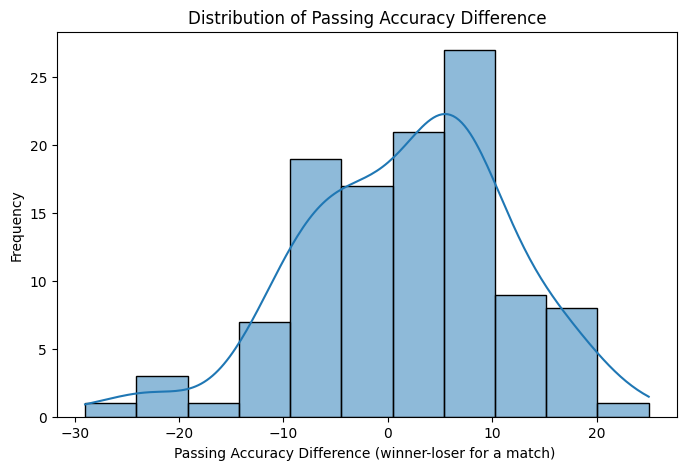

In [15]:
# Check the distribution of passing rates
passing_rate_diff = non_drawn_match['passing_rate_diff']

# Plot the distribution
plt.figure(figsize=(8, 5))
sns.histplot(passing_rate_diff, kde=True)
plt.title('Distribution of Passing Accuracy Difference')
plt.xlabel('Passing Accuracy Difference (winner-loser for a match) ')
plt.ylabel('Frequency')
plt.show()

##Below plot shows approximately bell shaped curve suggesting it has normal distribution

##Hypotheses Set Up

###Null Hypothesis (H0): There would not be any bias between passing rate difference and (outcome) win or loss in the match . This means the mean difference in passing rates (winner passing rate - loser passing rate) would be zero.
H0: μ =0
###Alternative Hypothesis (H1): Winners have a higher passing rate than losers, which means the mean difference in passing rates is greater than zero.
H1: μ >0


Key Considerations for Choosing Null and Alternative Hypotheses:
Conventional Setup:


Null Hypothesis (H0) is usually the statement of "no effect" or "no difference." It's the default assumption that there is no change, no effect, or no association between two measured phenomena.

Alternative Hypothesis (H1) represents what you aim to prove or expect based on your research question. It is a statement that there is an effect, a difference, or an association.

*******************************************



One Sample T-Test

## Manual Calculation for One Sample T test

In [16]:
# Calculate the necessary statistics for the t-test formula

sample_mean = round(non_drawn_match['passing_rate_diff'].mean(),3)
sample_std = round(non_drawn_match['passing_rate_diff'].std(ddof=1),3)
sample_size = non_drawn_match.shape[0]
degree_of_freedom = sample_size - 1
 # μ = 0 as per our null hypothesis
population_mean = 0
print(f"Sample Mean (X̄): {sample_mean}")
print(f"Sample Standard Deviation (S): {sample_std}")
print(f"Sample Size (n): {sample_size}")
print(f"Population Mean (μ): {population_mean}")
print(f"Degree of Freedom: {degree_of_freedom}")

# Calculate the t-statistic manually
t_stat = (sample_mean - population_mean) / (sample_std / (math.sqrt(sample_size)))

print(f"T-statistic (T): {t_stat:.3f}")

Sample Mean (X̄): 1.816
Sample Standard Deviation (S): 9.888
Sample Size (n): 114
Population Mean (μ): 0
Degree of Freedom: 113
T-statistic (T): 1.961


## Calculation of t-stat and p-value using One Sample T test Statistical Model leveraging scipy.stats.ttest_1samp model

In [17]:
from scipy.stats import ttest_1samp

# Perform the one-sample t-test
test_statistic, p_value = ttest_1samp(non_drawn_match['passing_rate_diff'], 0, alternative='greater')

print(f"T-statistic (T): {test_statistic:.3f}")
print(f"P-Value: {p_value:.3f}")

T-statistic (T): 1.961
P-Value: 0.026


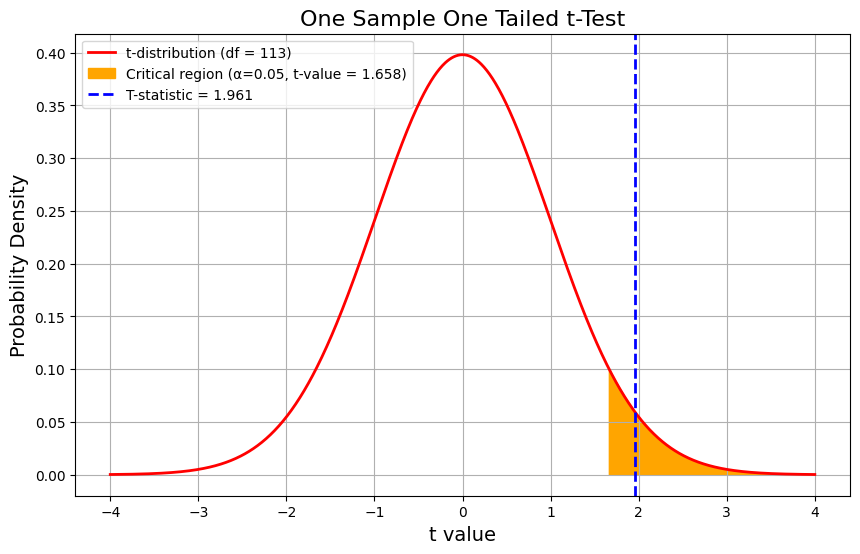

In [18]:
from scipy.stats import t

# Create the figure
plt.figure(figsize=(10, 6))

alpha = 0.05  # Significance level
df = 113       # Degrees of freedom

#critical_t_value for One tailed test
critical_t_value = round(t.ppf(1 - alpha, df),3)
#critical_t_value=1.658


x = np.linspace(-4, 4, 1000)
# Calculate the t-distribution values for y
y = t.pdf(x, df=degree_of_freedom)

# Plot the t-distribution curve with similar styling
plt.plot(x, y, label=f't-distribution (df = {degree_of_freedom})', color='red', linewidth=2)

# Highlighting the critical region with similar styling
plt.fill_between(x, 0, y, where=(x > critical_t_value), color='orange', label='Critical region (α=0.05, '+ f't-value = {critical_t_value})')

# Marking the t-statistic with similar styling
plt.axvline(x=t_stat, color='blue', linestyle='--', linewidth=2, label=f'T-statistic = {t_stat:.3f}')

# Adding titles and labels similar to the uploaded image
plt.title('One Sample One Tailed t-Test', fontsize=16)
plt.xlabel('t value', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)
plt.legend(fontsize=10,loc='upper left')
plt.grid(True)

# Show the plot
plt.show()

#Question 2
#Is there statistically significant difference in passing accuracy between two team for two groups – drawn matches and non-draw matches ?

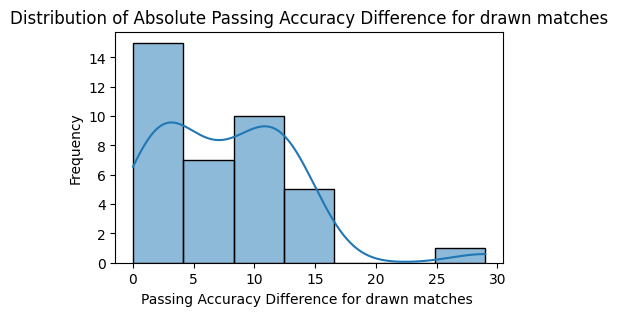

In [19]:

# Check the distribution of absolute passing rate difference for drawn games
draw_abs_passing_rate_diff = match_data[match_data["game_draw"] == True ]['abs_passing_rate_diff']

# Plot the distribution
plt.figure(figsize=(5, 3))
sns.histplot(draw_abs_passing_rate_diff, kde=True)
plt.title('Distribution of Absolute Passing Accuracy Difference for drawn matches')
plt.xlabel('Passing Accuracy Difference for drawn matches ')
plt.ylabel('Frequency')
plt.show()

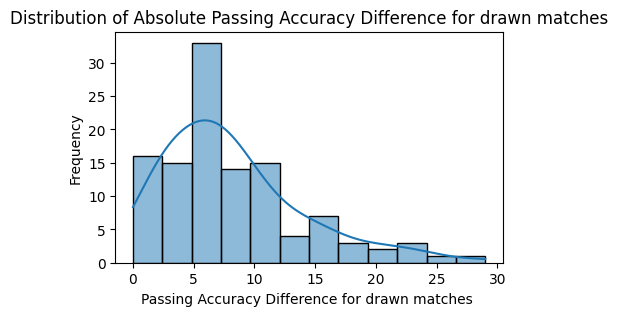

In [20]:

# Check the distribution of absolute passing rate difference for drawn games
non_draw_abs_passing_rate_diff = match_data[match_data["game_draw"] == False ]['abs_passing_rate_diff']

# Plot the distribution
plt.figure(figsize=(5, 3))
sns.histplot(non_draw_abs_passing_rate_diff, kde=True)
plt.title('Distribution of Absolute Passing Accuracy Difference for drawn matches')
plt.xlabel('Passing Accuracy Difference for drawn matches ')
plt.ylabel('Frequency')
plt.show()

In [22]:
# Extract data for games with a winner and games that ended in a draw
non_draw_group = match_data[match_data["game_draw"] == False]['abs_passing_rate_diff']
draw_group = match_data[match_data["game_draw"] == True]['abs_passing_rate_diff']

In [23]:
draw_group.describe()

count    38.000000
mean      7.684211
std       5.798906
min       0.000000
25%       3.000000
50%       8.000000
75%      12.000000
max      29.000000
Name: abs_passing_rate_diff, dtype: float64

In [24]:
non_draw_group.describe()

count    114.000000
mean       8.166667
std        5.815628
min        0.000000
25%        4.000000
50%        7.000000
75%       10.000000
max       29.000000
Name: abs_passing_rate_diff, dtype: float64

**Null Hypothesis (H0): There is no difference in the expected difference in passing rate in games that end in a draw from the expected difference in passing rate in games with a winner.**

This hypothesis suggests that having a decisive winner does not result in a larger discrepancy in passing rates compared to games that end in a draw.

**Alternative Hypothesis (H1): The expected difference in passing rate in games that end in a draw is different from the expected difference in passing rate in games with a winner.**


## Manual Calculation for Mann Whitney Test

In [32]:
from scipy.stats import rankdata, norm

# Combine the data from both groups
combined_data = np.concatenate((draw_group, non_draw_group))

# Rank the combined data
ranks = rankdata(combined_data)

# Calculate the sum of ranks for each group
rank_sum_draw = ranks[:len(draw_group)].sum()
rank_sum_non_draw = ranks[len(draw_group):].sum()

print(f"Sum of Rank for Drawn Games: {rank_sum_draw}")
print(f"Sum of Rank for Non-Draw Games: {rank_sum_non_draw}")

# Calculate the U statistic for each group
n1 = len(draw_group)
n2 = len(non_draw_group)

U_draw = n1 * n2 + (n1 * (n1 + 1)) / 2 - rank_sum_draw
U_non_draw = n1 * n2 + (n2 * (n2 + 1)) / 2 - rank_sum_non_draw

print(f"U Statistic for Drawn Games: {U_draw}")
print(f"U Statistic for Non-Draw Games: {U_non_draw}")

# The smaller U statistic is used for the test
U = min(U_draw, U_non_draw)
print(f"U Statistic: {U}")

# Calculate the mean and standard deviation of U
mean_U = n1 * n2 / 2
std_U = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)

# Calculate the z value
z = (U - mean_U) / std_U
print(f"Mean Value: {mean_U}")
print(f"Standard Deviation: {std_U:.2f}")
print(f"Z- Value: {z:.3f}")

Sum of Rank for Drawn Games: 2831.0
Sum of Rank for Non-Draw Games: 8797.0
U Statistic for Drawn Games: 2242.0
U Statistic for Non-Draw Games: 2090.0
U Statistic: 2090.0
Mean Value: 2166.0
Standard Deviation: 235.02
Z- Value: -0.323


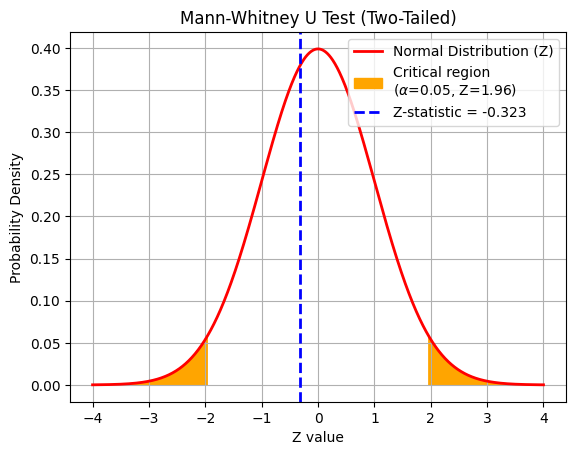

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Given values
z_value = z
critical_value = 1.96
alpha = 0.05

# Generate x values for the plot
x = np.linspace(-4, 4, 1000)

# Calculate the normal distribution values for y
y = stats.norm.pdf(x)

# Plot the normal distribution
plt.plot(x, y, label='Normal Distribution (Z)', color='red', linewidth=2)

# Fill the critical region (two-tailed)
plt.fill_between(x, y, where=(x >= critical_value) | (x <= -critical_value), color='orange',  label=f'Critical region\n($\\alpha$={alpha}, Z={critical_value:.2f})')

# Plot the Z statistic
plt.axvline(z_value, color='blue', linestyle='--', linewidth=2, label=f'Z-statistic = {z_value:.3f}')

# Add labels and legend
plt.title('Mann-Whitney U Test (Two-Tailed)')
plt.xlabel('Z value')
plt.ylabel('Probability Density')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

## Calculation of u test stat and p-value using Mann Whitney test Statistical Model leveraging scipy.stats.mannwhitneyu model

In [36]:
from scipy.stats import mannwhitneyu


# Perform the Mann-Whitney U test
u_statistic, p_value = mannwhitneyu(draw_group, non_draw_group, alternative='two-sided')

print(f"Mann-Whitney U test statistic: {u_statistic}, P-value: {p_value}")

Mann-Whitney U test statistic: 2090.0, P-value: 0.7474730416644133
